In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Epsilon
EPSILON = 1e-8 # Constant to avoid the underflow or divide by 0
%matplotlib inline

## Load Dataset

In [2]:
digits = load_digits()

print(digits['data'])
digits['target']

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


array([0, 1, 2, ..., 8, 9, 8])

In [3]:
dataset = 'MNSIT'

def load_data(dataset='MNIST'):
    if dataset == "MNIST":
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow.keras.datasets as datasets
        fashion_mnist = datasets.fashion_mnist.load_data()
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y

X, Y = load_data()

In [4]:
print(X)
print(Y)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [5]:
n_classes = len(np.unique(Y))

In [6]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1]))  # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [7]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


## View Data

In [8]:
def view_data(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = np.random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title('Image Label: %d' % Y[index])
    plt.tight_layout()
    plt.show()

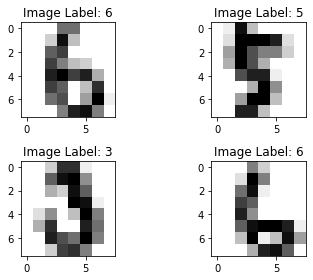

In [9]:
view_data(X, Y)

## Multi Layer Perceptron
We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}_i ; \mathbf{\Theta})^\top y_i
$$

### Objectives
1. Write the categorical cross entropy loss function
2. Write the activation functions with their associated gradient
3. Write the softmax function that is going to be used to output the predicted probabilities
4. Implement the forward pass through the neural network
5. Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
6. Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
7. Implement the SGD optimization algorithm, and improve it with simple momentum



We have: $outer(u, v) = u \cdot v^T$, with $u, v$ two vectors

In [10]:
# Example:
u, v = np.random.normal(size=(5,)), np.random.normal(size=(10,))
assert np.array_equal(
    np.outer(u, v),
    np.dot(np.reshape(u, (u.size, 1)), np.reshape(v, (1, v.size)))
)


assert np.outer(u, v).shape == (5, 10)

In [11]:
print(u)

print(v)

[ 0.25646382 -0.60842636 -0.78545851 -0.24910426  0.33030675]
[-1.70053869  0.0402017   0.07496032 -0.11615448  0.01582436  0.09238161
 -0.17457162 -1.71964432  0.26615044 -1.21643051]


## Implement

In [23]:
class MultiLayerPerceptron():
    '''It has one hidden layer with a hidden activation and one output layer having a softmax activation'''
    def __init__(self, X, Y, hidden_size, activation='relu', initialization='uniform', dropout=False, dropout_rate=1):
        # input, hidden and output dimensions on the MLP based on X, Y 
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of weight matrices
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.hidden_size, self.input_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.output_size, self.hidden_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.hidden_size, self.input_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.output_size, self.hidden_size), loc=0, scale=0.01)
        
        # the bias could be initialized to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        
        # Structure of Gradients (namedTuple)
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        
        # Velocities associated which are going to be useful for the momentum 
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        
        # Hidden activation
        self.activation = activation
        
        # list to track losses and accuracies
        self.train_loss_history = []
        self.val_losses_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        
        # Train test split and normalization of the features
        self.X_train, self.X_test, self.Y_train, self.Y_test = self.split_train_test(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
        # dropout params
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        
        # Step for optimization (lr)
        self.step = 0
    
    # One hot encoding of the target, Transform the integer representation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover from the former integer representation 
    # Eg: from  (0, 0, 1, 0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot == 1)[1], dtype=np.int32)
    
    
    '''
    Activation Function and their Gradient
    '''
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        return np.clip(X, 0, max_value) 
    
    # Make it so the gradient becomes 0 when X becomes greater than the max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        assert max_value > 0
        grad_logic = (X >= 0) * (X < max_value)
        return grad_logic.astype(int)
    
    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    @staticmethod
    def grad_sigmoid(X):
        return self.sigmoid(X) * (1 - self.sigmoid(X))
    
    # SoftMax Function to output probabilities
    @staticmethod
    def softmax(X):
        return np.exp(X) / np.sum(np.exp(X))
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        return -np.mean(np.log(Y_pred) * Y_true)
    
    @staticmethod
    def split_train_test(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_train, X_test, Y_train, Y_test
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
    
    
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, train=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
        
        z_h = np.dot(self.W_h, X.T).T + self.b_h # Z = W.X + b
        h = g_activation(z_h)
        
        if self.dropout:
            if train:
                dropout_vec = np.random.binomial(1, 1 - self.dropout_rate, h.shape)
                h *= dropout_vec
            else:
                h *= self.dropout_rate
        
        z_o = np.dot(self.W_o, h.T).T + self.b_o
        y = self.softmax(z_o)
        
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def backward(self, X, Y, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.hidden_size, self.input_size))
            grad_b_h = np.zeros((self.hidden_size, )) 
            grad_W_o = np.zeros((self.output_size, self.hidden_size))
            grad_b_o = np.zeros((self.output_size, ))
            
            for x, Y_true in zip(X, Y):
                y_pred, h, z_h = self.forward(x, return_activation=True, train=True)
                # Compute the activation gradients
                grad_z_o = y_pred - self.one_hot(self.output_size, Y_true)
                
                # Compute the last layer parameters gradients
                grad_W_o += np.outer(grad_z_o, h.T)                
                grad_b_o += grad_z_o
                
                # Compute the First layer activation gradients
                grad_h = np.dot(self.W_o.T, grad_z_o)
                grad_z_h = np.multiply(grad_h, g_grad(z_h))
                
                # Compute the First layer parameter gradients
                grad_W_h += np.outer(grad_z_h, x.T)
                grad_b_h += grad_z_h
            
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
        
        else:
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)
            
            # try to do the backprop without Python loops in a vectorized way:
            grad_W_h = np.zeros((X.shape[0], self.hidden_size, self.input_size))
            grad_b_h = np.zeros((X.shape[0], self.hidden_size, )) 
            grad_W_o = np.zeros((X.shape[0], self.output_size, self.hidden_size))
            grad_b_o = np.zeros((X.shape[0], self.output_size, ))
            
            grads = self.Grads(
                np.mean(grad_W_h, axis=0), 
                np.mean(grad_b_h, axis=0), 
                np.mean(grad_W_o, axis=0), 
                np.mean(grad_b_o, axis=0)
            )
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, batch_size=None, vectorized=True):
        if optimizer == 'gd': # Gradient Descent
            grads = self.backward(self.X_train, self.Y_train, vectorized=vectorized)
        elif optimizer == 'sgd': # SGD
            batch_X_train, batch_Y_train = self.get_random_batch(self.X_train, self.Y_train, batch_size)
            grads = self.backward(batch_X_train, batch_Y_train, vectorized=vectorized)
        else:
            raise NotImplementedError
        
        if not momentum:
            self.W_h -= self.step * grads.W_h
            self.b_h -= self.step * grads.b_h
            self.W_o -= self.step * grads.W_o
            self.b_o -= self.step * grads.b_o
        else:
            # remember: use the stored velocities
            # TODO : compute velocities update for momentum
            self.velocities['W_h'] = momentum_alpha * self.velocities['W_h'] - self.step * grads.W_h
            self.velocities['W_o'] = momentum_alpha * self.velocities['W_o'] - self.step * grads.W_o
            self.velocities['b_h'] = momentum_alpha * self.velocities['b_h'] - self.step * grads.b_h
            self.velocities['b_o'] = momentum_alpha * self.velocities['b_o'] - self.step * grads.b_o
            # update parameters
            self.W_h += self.velocities['W_h']
            self.b_h += self.velocities['b_h']
            self.W_o += self.velocities['W_o']
            self.b_o += self.velocities['b_o']
            
            pass
    
    # Loss Wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.train_loss_history = []
        self.val_loss_history = []
    
    # EarlyStopping prevents unneccessary iterations
    # Dropout-> To prevent OverFitting
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=5000, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.train_loss_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
            )
            
            training_loss = self.loss(self.Y_train, self.forward(self.X_train))
            self.train_loss_history.append(training_loss)
            training_accuracy = self.accuracy_on_train()
            self.train_acc_history.append(training_accuracy)
            validation_loss = self.loss(self.Y_test, self.forward(self.X_test))
            self.val_loss_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.val_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss, 
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
     # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_train, normalize=False) == self.Y_train).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_test, normalize=False) == self.Y_test).mean()
    
    def plot_loss_history(self, add_to_title=None):
        import warnings
        warnings.filterwarnings("ignore")
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.train_loss_history)), 
                 self.train_loss_history, label='Training loss evolution')
        plt.plot(range(len(self.val_loss_history)), 
                 self.val_loss_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.1f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
    
    def plot_test_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_train)
        dim = np.sqrt(self.X_test.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_test[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_test[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_test[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_test[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_test[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

In [25]:
model = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu')
model.train()

iteration number: 1	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0911
iteration number: 2	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0822
iteration number: 3	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0822
iteration number: 4	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0911
iteration number: 5	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.1133
iteration number: 6	 training loss: 0.9508	validation loss: 0.8411	 validation accuracy: 0.0911
iteration number: 7	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0911
iteration number: 8	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0911
iteration number: 9	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.1022
iteration number: 10	 training loss: 0.9508	validation loss: 0.8412	 validation accuracy: 0.0933
iteration number: 11	 training loss: 0.

iteration number: 97	 training loss: 0.9489	validation loss: 0.8402	 validation accuracy: 0.1133
iteration number: 98	 training loss: 0.9488	validation loss: 0.8401	 validation accuracy: 0.1444
iteration number: 99	 training loss: 0.9488	validation loss: 0.8401	 validation accuracy: 0.1378
iteration number: 100	 training loss: 0.9487	validation loss: 0.8401	 validation accuracy: 0.1067
iteration number: 101	 training loss: 0.9486	validation loss: 0.8401	 validation accuracy: 0.0978
iteration number: 102	 training loss: 0.9485	validation loss: 0.8400	 validation accuracy: 0.0889
iteration number: 103	 training loss: 0.9485	validation loss: 0.8399	 validation accuracy: 0.0667
iteration number: 104	 training loss: 0.9484	validation loss: 0.8398	 validation accuracy: 0.0644
iteration number: 105	 training loss: 0.9483	validation loss: 0.8398	 validation accuracy: 0.0644
iteration number: 106	 training loss: 0.9482	validation loss: 0.8398	 validation accuracy: 0.0644
iteration number: 107	 

iteration number: 187	 training loss: 0.9102	validation loss: 0.8070	 validation accuracy: 0.3200
iteration number: 188	 training loss: 0.9093	validation loss: 0.8062	 validation accuracy: 0.3333
iteration number: 189	 training loss: 0.9083	validation loss: 0.8054	 validation accuracy: 0.3356
iteration number: 190	 training loss: 0.9073	validation loss: 0.8043	 validation accuracy: 0.3533
iteration number: 191	 training loss: 0.9062	validation loss: 0.8033	 validation accuracy: 0.3444
iteration number: 192	 training loss: 0.9053	validation loss: 0.8023	 validation accuracy: 0.3422
iteration number: 193	 training loss: 0.9040	validation loss: 0.8010	 validation accuracy: 0.3822
iteration number: 194	 training loss: 0.9028	validation loss: 0.7999	 validation accuracy: 0.3844
iteration number: 195	 training loss: 0.9018	validation loss: 0.7983	 validation accuracy: 0.4356
iteration number: 196	 training loss: 0.9007	validation loss: 0.7973	 validation accuracy: 0.4267
iteration number: 19

iteration number: 270	 training loss: 0.8325	validation loss: 0.7283	 validation accuracy: 0.7822
iteration number: 271	 training loss: 0.8323	validation loss: 0.7277	 validation accuracy: 0.7911
iteration number: 272	 training loss: 0.8329	validation loss: 0.7286	 validation accuracy: 0.7867
iteration number: 273	 training loss: 0.8342	validation loss: 0.7296	 validation accuracy: 0.7778
iteration number: 274	 training loss: 0.8320	validation loss: 0.7268	 validation accuracy: 0.8067
iteration number: 275	 training loss: 0.8326	validation loss: 0.7271	 validation accuracy: 0.8133
iteration number: 276	 training loss: 0.8322	validation loss: 0.7265	 validation accuracy: 0.8111
iteration number: 277	 training loss: 0.8312	validation loss: 0.7251	 validation accuracy: 0.8178
iteration number: 278	 training loss: 0.8305	validation loss: 0.7258	 validation accuracy: 0.7911
iteration number: 279	 training loss: 0.8296	validation loss: 0.7250	 validation accuracy: 0.7822
iteration number: 28

iteration number: 365	 training loss: 0.8218	validation loss: 0.7151	 validation accuracy: 0.8800
iteration number: 366	 training loss: 0.8218	validation loss: 0.7149	 validation accuracy: 0.8778
iteration number: 367	 training loss: 0.8224	validation loss: 0.7162	 validation accuracy: 0.8756
iteration number: 368	 training loss: 0.8250	validation loss: 0.7202	 validation accuracy: 0.8600
iteration number: 369	 training loss: 0.8271	validation loss: 0.7232	 validation accuracy: 0.8622
iteration number: 370	 training loss: 0.8266	validation loss: 0.7226	 validation accuracy: 0.8644
iteration number: 371	 training loss: 0.8270	validation loss: 0.7222	 validation accuracy: 0.8733
iteration number: 372	 training loss: 0.8289	validation loss: 0.7234	 validation accuracy: 0.8622
iteration number: 373	 training loss: 0.8291	validation loss: 0.7222	 validation accuracy: 0.8689
iteration number: 374	 training loss: 0.8279	validation loss: 0.7210	 validation accuracy: 0.8778
iteration number: 37

iteration number: 457	 training loss: 0.8448	validation loss: 0.7360	 validation accuracy: 0.9067
iteration number: 458	 training loss: 0.8426	validation loss: 0.7349	 validation accuracy: 0.9067
iteration number: 459	 training loss: 0.8429	validation loss: 0.7340	 validation accuracy: 0.9133
iteration number: 460	 training loss: 0.8483	validation loss: 0.7390	 validation accuracy: 0.9111
iteration number: 461	 training loss: 0.8451	validation loss: 0.7344	 validation accuracy: 0.9089
iteration number: 462	 training loss: 0.8421	validation loss: 0.7326	 validation accuracy: 0.8978
iteration number: 463	 training loss: 0.8428	validation loss: 0.7334	 validation accuracy: 0.9022
iteration number: 464	 training loss: 0.8437	validation loss: 0.7346	 validation accuracy: 0.9089
iteration number: 465	 training loss: 0.8404	validation loss: 0.7321	 validation accuracy: 0.9044
iteration number: 466	 training loss: 0.8419	validation loss: 0.7331	 validation accuracy: 0.9000
iteration number: 46

iteration number: 543	 training loss: 0.8607	validation loss: 0.7491	 validation accuracy: 0.9133
iteration number: 544	 training loss: 0.8519	validation loss: 0.7416	 validation accuracy: 0.9022
iteration number: 545	 training loss: 0.8550	validation loss: 0.7420	 validation accuracy: 0.9111
iteration number: 546	 training loss: 0.8522	validation loss: 0.7403	 validation accuracy: 0.9156
iteration number: 547	 training loss: 0.8536	validation loss: 0.7381	 validation accuracy: 0.9289
iteration number: 548	 training loss: 0.8553	validation loss: 0.7399	 validation accuracy: 0.9222
iteration number: 549	 training loss: 0.8576	validation loss: 0.7438	 validation accuracy: 0.9089
iteration number: 550	 training loss: 0.8611	validation loss: 0.7474	 validation accuracy: 0.9089
iteration number: 551	 training loss: 0.8584	validation loss: 0.7475	 validation accuracy: 0.9111
iteration number: 552	 training loss: 0.8612	validation loss: 0.7505	 validation accuracy: 0.9022
iteration number: 55

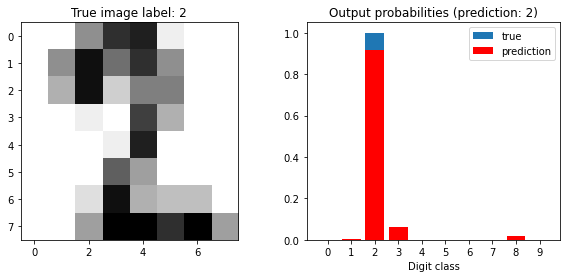

In [29]:
model.plot_test_prediction(sample_id=41)

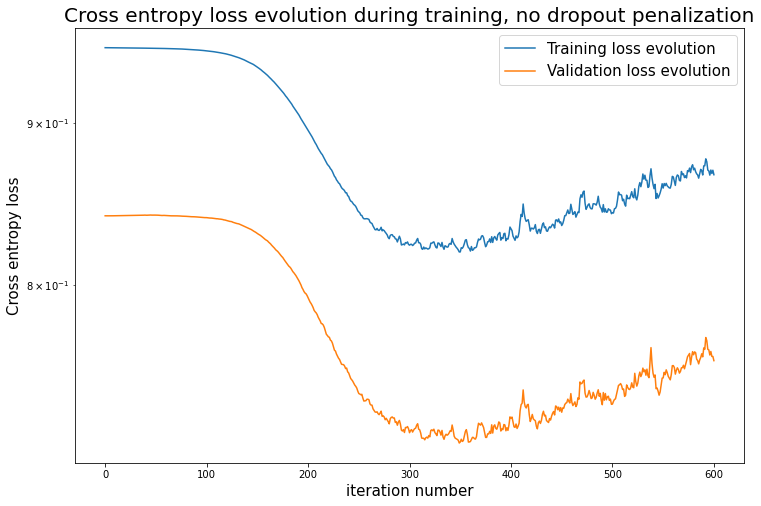

In [30]:
model.plot_loss_history()

We got 91% accuracy
1. Using SGD as optimizer makes the training quite fast, while the batch gradient takes much longer. However, we do get similar results using the two techniques.

### Check Results with these params
1. Hidden size = 100 , activation function = relu, initial step = 0.01, batch size=64
2. Hidden size = 50, activation function = relu, initial step = 0.001, batch size =64

Dropout prevents overfitting by ensuring that all neurons are used during training

Once properly implemented, compare the training using momentum.

## Multiclass classification MLP with Keras (TF)
 Implement the same network architecture with Keras;
- First using the Sequential API
- Secondly using the functional API

- Check that the Keras model can approximately reproduce the behavior of the Numpy model.
- Compute the negative log likelihood of a sample 42 in the test set (can use model.predict_prob).
- Compute the average negative log-likelihood on the full test set.
- Compute the average negative log-likelihood on the full training set and check that you can get the value of the loss reported by Keras.
- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[0.    , 0.125 , 0.75  , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.375 , ..., 0.9375, 1.    , 1.    ],
       [0.    , 0.    , 0.0625, ..., 0.4375, 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.1875, ..., 0.3125, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float32)

In [35]:
n_features = X[0].shape[0]
n_classes = len(np.unique(Y_train))
n_hidden = 10

n_classes

10

### Sequential

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy

activation = 'relu'

model = Sequential([
    Dense(n_hidden, activation=activation),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='Adam', loss=sparse_categorical_crossentropy)

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50)

Epoch 1/50
43/43 [==============================] - 1s 14ms/step - loss: 2.2566 - val_loss: 2.1935
Epoch 2/50
43/43 [==============================] - 0s 8ms/step - loss: 2.1194 - val_loss: 2.0555
Epoch 3/50
43/43 [==============================] - 0s 7ms/step - loss: 1.9688 - val_loss: 1.9087
Epoch 4/50
43/43 [==============================] - 0s 9ms/step - loss: 1.8170 - val_loss: 1.7566
Epoch 5/50
43/43 [==============================] - 0s 9ms/step - loss: 1.6597 - val_loss: 1.5996
Epoch 6/50
43/43 [==============================] - 0s 9ms/step - loss: 1.5009 - val_loss: 1.4358
Epoch 7/50
43/43 [==============================] - 0s 10ms/step - loss: 1.3404 - val_loss: 1.2718
Epoch 8/50
43/43 [==============================] - 0s 8ms/step - loss: 1.1560 - val_loss: 1.0963
Epoch 9/50
43/43 [==============================] - 0s 8ms/step - loss: 0.9821 - val_loss: 0.9562
Epoch 10/50
43/43 [==============================] - 0s 9ms/step - loss: 0.8466 - val_loss: 0.8373
Epoch 11/50
43/43

In [41]:
# Predict
#pred = model.predict(X_test)
pred = model.predict(X)
#pred = model.predict_proba(X)
print(pred[6])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0666352e-37
 0.0000000e+00 1.0000000e+00 0.0000000e+00 2.5814211e-25 0.0000000e+00]


### Functional

In [44]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import time
activation = 'relu'
print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
x = layers.Dense(n_hidden, activation=activation)(inputs)

outputs = layers.Dense(n_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name='functional_Model')

model.compile(optimizer='Adam', loss=sparse_categorical_crossentropy)
start = time.time()
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=500)
finish = time.time() - start
print('Finished in %s'%finish)

Model with relu activation
Epoch 1/500
43/43 [==============================] - 0s 4ms/step - loss: 2.2780 - val_loss: 2.1994
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 2.1430 - val_loss: 2.1006
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 2.0301 - val_loss: 1.9808
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 1.8917 - val_loss: 1.8279
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 1.7147 - val_loss: 1.6309
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 1.5247 - val_loss: 1.4497
Epoch 7/500
43/43 [==============================] - 0s 2ms/step - loss: 1.3497 - val_loss: 1.2923
Epoch 8/500
43/43 [==============================] - 0s 2ms/step - loss: 1.1948 - val_loss: 1.1550
Epoch 9/500
43/43 [==============================] - 0s 2ms/step - loss: 1.0612 - val_loss: 1.0401
Epoch 10/500
43/43 [==============================] - 0s 2ms/step - loss: 0.9504 -

43/43 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.1739
Epoch 83/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.1732
Epoch 84/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.1720
Epoch 85/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.1712
Epoch 86/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.1715
Epoch 87/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.1690
Epoch 88/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.1689
Epoch 89/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.1692
Epoch 90/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.1683
Epoch 91/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.1682
Epoch 92/500


43/43 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.1488
Epoch 164/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.1474
Epoch 165/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.1475
Epoch 166/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.1472
Epoch 167/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.1476
Epoch 168/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1486
Epoch 169/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1468
Epoch 170/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.1472
Epoch 171/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1475
Epoch 172/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1482
Epoc

43/43 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.1530
Epoch 245/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.1544
Epoch 246/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.1527
Epoch 247/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.1531
Epoch 248/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.1535
Epoch 249/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.1526
Epoch 250/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.1534
Epoch 251/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.1536
Epoch 252/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.1546
Epoch 253/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.1533
Epoc

43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.1675
Epoch 326/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.1694
Epoch 327/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.1675
Epoch 328/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.1697
Epoch 329/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.1698
Epoch 330/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.1699
Epoch 331/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.1701
Epoch 332/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.1726
Epoch 333/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.1711
Epoch 334/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.1700
Epoc

43/43 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.1859
Epoch 407/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.1864
Epoch 408/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.1880
Epoch 409/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.1881
Epoch 410/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.1866
Epoch 411/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.1890
Epoch 412/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.1874
Epoch 413/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.1886
Epoch 414/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.1882
Epoch 415/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.1883
Epoc

43/43 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.2051
Epoch 488/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.2067
Epoch 489/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.2078
Epoch 490/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.2072
Epoch 491/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.2077
Epoch 492/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.2089
Epoch 493/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.2092
Epoch 494/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.2092
Epoch 495/500
43/43 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.2097
Epoch 496/500
43/43 [==============================] - 0s 2ms/step - loss: 9.6418e-04 - val_loss: 0.2093
